In [37]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.optimize import root_scalar

In [33]:

global dt
global psi
global c
global v
global n
global k
global radius
global rho_o
global control_signal
global control_hold
global control_rate
global theta_dot_save
global gamma_save


theta_dot_save = []
gamma_save = []

control_time_delay = 0.1

control_hold = 0
dt = 0.01
control_rate = int(control_time_delay/dt)
c = 1.1
psi = np.pi*(3.01/2)
cj = 1.1

kj = 0.1

v = 0.2
n = 4
k = 0.1
radius = 0.6
d_0 = 2*np.sin((2*np.pi/n)/2)*radius
lambda_v = np.exp((2*v)/(k*radius*np.pi))
rho_o = ((c-1)*radius)/((lambda_v*c) - 1)
control_signal = []

###############
c = 2
psi = np.pi*(7/4)
cj = 2
 
kj = 0.09

v = 1
n = 4
k = 0.05
radius = 0.6
d_0 = 10
lambda_v = np.exp((2*v)/(k*radius*np.pi))
rho_o = 12
control_signal = []


Dynamics :

$\dot{x}(t) = v\cos \theta (t)\\$
$\dot{y}(t) = v\sin \theta (t)\\$
$\dot{theta}(t) = u(t)\\$

Control Law for one vehicle : 

$$
    u(t)= 
\begin{cases}
    k \cdot g(\rho (t) ; c,\rho_0) \cdot \alpha_d(\gamma(t)) ,& \text{if } \rho(t) > 0\\
    0,              & \text{if } \rho(t) = 0
\end{cases} \\
$$
with
$$
g(\rho ; c,\rho_0) = ln\Big (\frac{(c-1)\cdot \rho + \rho_0}{c \cdot \rho_0}\Big )\\
$$

$$
\alpha_d(\gamma) = \begin{cases}
    \gamma ,& \text{if } 0 \leq \gamma \leq \psi\\
    \gamma - 2 \pi,              & \text{if } \psi < \gamma \leq 2 \pi
\end{cases} \\
$$

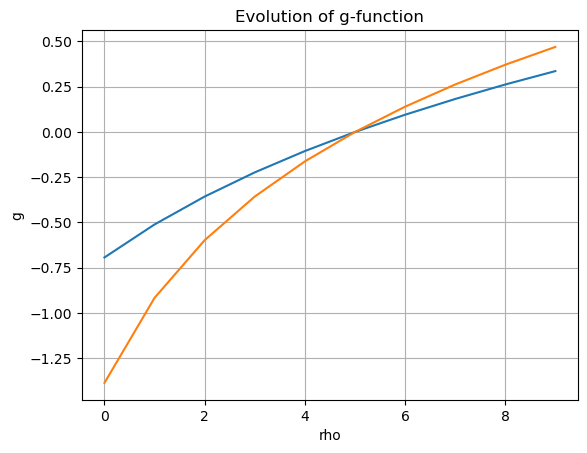

In [32]:
op1 = []
op2 = []
var_0 = 5
var_c1 = 2
var_c2 = 4
for var in range(10):
    op1.append(np.log((((var_c1-1)*var) + var_0)/(var_c1*var_0)))
    op2.append(np.log((((var_c2-1)*var) + var_0)/(var_c2*var_0)))
plt.plot(op1)
plt.plot(op2)

plt.title("Evolution of g-function")
plt.grid(True)
plt.xlabel('rho')
plt.ylabel('g')
plt.show()


In [35]:

def g_function2(rho_e,c,rho_o):
    g1 = np.log((((c-1)*rho_e) + rho_o)/(c*rho_o))
    if (rho_e<0.000000001):
        g1 = 0
    return g1
def g_function(xb,xv,c,rho_o):
    rho_v = np.array(xb) - np.array(xv)
    rho = np.linalg.norm(rho_v)
    g = np.log((((c-1)*rho) + rho_o)/(c*rho_o))
    if (rho<0.000000001):
        g = 0
    return g
def alpha_d(gamma,psi):
    if ((gamma>=0)and (gamma <=psi)):
        return gamma
    elif ((gamma>psi)and (gamma <2*np.pi)):
        return gamma - 2*np.pi
    else :
        print("Error in gamma value" + gamma)

def dist(a,b):
    d = np.array(a) - np.array(b)
    d = np.linalg.norm(d)
    return d

def u_t(xv,xb,heading):
    gamma = get_angle(xb[0] - xv[0],xb[1] - xv[1]) - heading
    while (gamma>2*np.pi):
        gamma = gamma -2*np.pi
    while (gamma<0):
        gamma = gamma + 2*np.pi
    #print(np.rad2deg(gamma))
    alpha = alpha_d(gamma,psi)

    g = g_function(xb,xv,c,rho_o)
    
    u = k*g*alpha
    if dist(xv,xb) < 0.1:
        u = 0
    control_signal.append(u)
    return u

def u_t_j(xv,xb,heading):
    gamma = get_angle(xb[0] - xv[0],xb[1] - xv[1]) - heading
   
    while (gamma>2*np.pi):
        gamma = gamma -2*np.pi
    while (gamma<0):
        gamma = gamma + 2*np.pi
    #print(np.rad2deg(gamma))
    alphaj = alpha_d(gamma,np.pi)

    gj = g_function(xb,xv,cj,d_0*4)
    
    u = kj*gj*alphaj
    if dist(xv,xb) < 0.2:
        u = 0
    control_signal.append(u)
    return u

def gamma_angle(xv,xb,heading):
    gamma = get_angle(xb[0] - xv[0],xb[1] - xv[1]) - heading
    while (gamma>2*np.pi):
        gamma = gamma -2*np.pi
    while (gamma<0):
        gamma = gamma + 2*np.pi
    return gamma

def velocity(t,n):
    return np.ones(n)*v
def adjust_angle(x,n):
    for i in range (n):
        while (x[(3*i)+2]>2*np.pi):
            x[(3*i)+2] = x[(3*i)+2] -2*np.pi
        while (x[(3*i)+2]<0):
            x[(3*i)+2] = x[(3*i)+2] + 2*np.pi

    
    return x

def f_unicycle(t,x,n):
    xb = np.array([4 , 4])
    v_vec = velocity(t,n)
    theta_dot_vec = []
    gamma_vec = []
    for i in range(n):
        theta_dot_vec.append(u_t(x[3*i:(3*i)+2],xb,x[(3*i)+2]) + u_t_j(x[3*i:(3*i)+2],x[3*((i+1)%n):(3*((i+1)%n))+2],x[(3*i)+2]))
        gamma_vec.append(gamma_angle(x[3*i:(3*i)+2],xb,x[(3*i)+2]) + u_t_j(x[3*i:(3*i)+2],x[3*((i+1)%n):(3*((i+1)%n))+2],x[(3*i)+2]))
    rhs = []
    theta_dot_save.append(theta_dot_vec)
    gamma_save.append(gamma_vec)

    for i in range(n):
        v = v_vec[i]
        theta_dot = theta_dot_vec[i]
        theta = x[(3*i) + 2]
        rhs.append([(v*np.cos(theta)),(v*np.sin(theta)),(theta_dot)])
    #theta_dot_save
    # print(rhs)
    rhs = np.array(rhs)
    rhs = rhs.flatten()
    return rhs
    # return theta_dot_vec
    
def rk4_step(f,x,t,dt,n):
    k1 = f(t,x,n)
    k2 = f(t + (0.5*dt),x + (0.5*k1*dt),n)
    k3 = f(t + (0.5*dt),x + (0.5*k2*dt),n)
    k4 = f(t + dt,x + (k3*dt),n)

    return dt*((k1 + (2*k2) + (2*k3) + k4)/6)


def get_angle(dx,dy):
    theta = np.arctan2(dy,dx)
    if(theta<0):
        theta = theta + 2*np.pi
    return theta


# def get_theta_dot(T,dt,t,x,n):
#     theta_dot = []
#     thet_dot = []
#     for i in tqdm(range(int(T/dt))):
#         thet_dot = f_unicycle(t,x,n)
#         x = x + dx
#         x = adjust_angle(x,n)
#         t = t + dt
#         theta_dot.append(thet_dot)
#     theta_dot = np.array(theta_dot)
#     return theta_dot




In [36]:
# x0 = np.array([0,0,0,
#                5,0,np.pi/2,
#                5,5,np.pi,
#                0,5,3*np.pi/2])
offset = 40
# x0 = np.array([0/10-offset,0/10-offset,0,
#                5/10-offset,0/10-offset,np.pi/2,
#                5/10-offset,5/10-offset,np.pi,
#                0/10-offset,5/10-offset,3*np.pi/2])
x0 = np.array([0/1-offset,0/1-offset,0,
               5/1-offset,0/1-offset,np.pi/2,
               5/1-offset,5/1-offset,np.pi,
               0/1-offset,5/1-offset,3*np.pi/2])

# x0 = np.array([0,0,0,
#                5,0,0.2,
#                3,7,0.3,
#                -2,8,0.4])

# x0 = np.array([2,0,1.57])
# x0 = np.array([0,0,1.57])
n = 4
traj = [x0]
x = x0
t = 0
T = 1500
global counter
counter = 0

for i in tqdm(range(int(T/dt) )):
    dx = rk4_step(f_unicycle,x,t,dt,n)
    x = x + dx
    x = adjust_angle(x,n)
    t = t + dt
    traj.append(x)
    counter += counter + 1 



100%|██████████| 150000/150000 [01:25<00:00, 1750.83it/s]


Velocity :  1


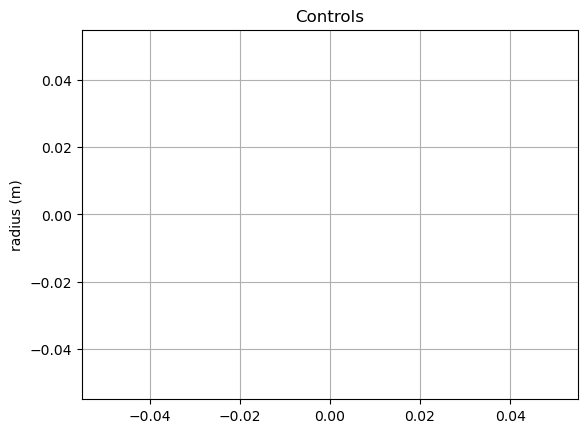

In [34]:
print("Velocity : ", v)
plt.plot(v/np.array(control_signal))
plt.title("Controls")
plt.grid(True)
plt.ylabel("radius (m)")
plt.show()

Velocity :  1


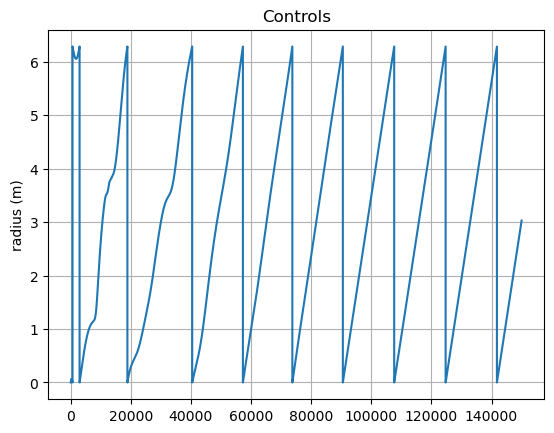

In [44]:
print("Velocity : ", v)
plt.plot(np.array(traj)[:,2])
plt.title("Controls")
plt.grid(True)
plt.ylabel("radius (m)")
plt.show()

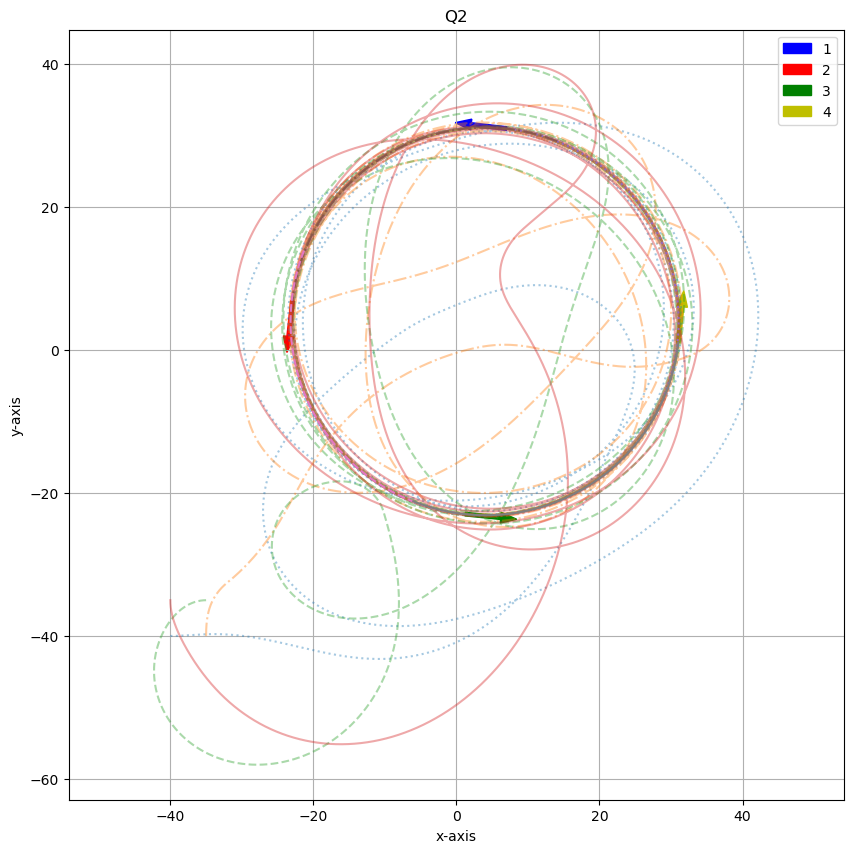

In [39]:
plt.figure(figsize=(10,10))
# plt.plot(np.array(traj)[:,0],np.array(traj)[:,1])
# plt.plot(np.array(traj)[:,2],np.array(traj)[:,3])
# plt.plot(np.array(traj)[:,4],np.array(traj)[:,5])
# plt.plot(np.array(traj)[:,6],np.array(traj)[:,7])
# plt.axis('equal')
# plt.show()
display_horizon = 5000
plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon,3],np.array(traj)[0:-display_horizon,4],'-.',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon:,6],np.array(traj)[0:-display_horizon,7],'--',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon,9],np.array(traj)[0:-display_horizon,10],alpha = 0.4)

plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,3],np.array(traj)[-display_horizon:-1,4],'-.',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,6],np.array(traj)[-display_horizon:-1,7],'--',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,9],np.array(traj)[-display_horizon:-1,10],alpha = 1)
plt.axis('equal')
plt.title('Q2')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

arrow_size = 5
plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=0.5,label = '1',color = 'b')
plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],arrow_size*np.cos(np.array(traj)[-1,5]),arrow_size*np.sin(np.array(traj)[-1,5]),width=0.5,label = '2',color = 'r')
plt.arrow(np.array(traj)[-1,6],np.array(traj)[-1,7],arrow_size*np.cos(np.array(traj)[-1,8]),arrow_size*np.sin(np.array(traj)[-1,8]),width=0.5,label = '3',color = 'g')
plt.arrow(np.array(traj)[-1,9],np.array(traj)[-1,10],arrow_size*np.cos(np.array(traj)[-1,11]),arrow_size*np.sin(np.array(traj)[-1,11]),width=0.5,label = '4',color = 'y')
plt.legend()
plt.grid()
plt.show()


In [47]:
#rho_e solver using root finding methods
def f(rho_e):
    return (v/rho_e) - k * g_function2(rho_e, c, rho_o) * (np.pi/2)

rho_guess = 1.0
rho_min = 0.1
rho_max = 70.0

solution = root_scalar(f, bracket=[rho_min, rho_max], method = 'brentq')
rho_e = solution.root
if solution.converged:
    root = solution.root
    print(f'solution found, rho_e = {root}')
else:
    print('no solution')



solution found, rho_e = 26.679025538938518


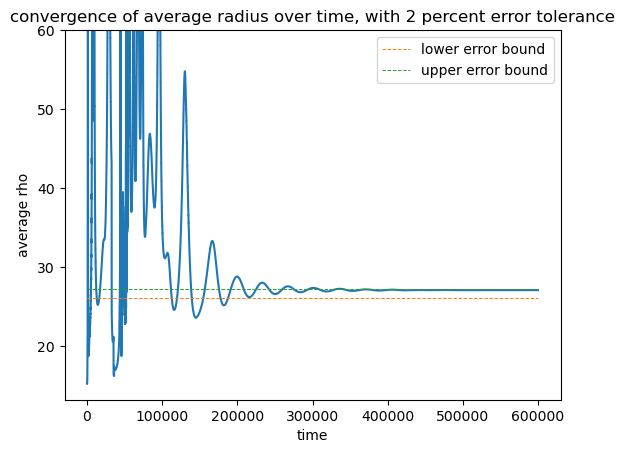

In [65]:
#plots average rotational radius
tol = 0.02
bound = [rho_e + rho_e * tol, rho_e - rho_e * tol]

theta_dot_save = np.array(theta_dot_save)
rho = abs(v / theta_dot_save) 
avg_rho = np.empty([rho.shape[0], 1])
time = np.arange(0,T,dt) 

for i in range(rho.shape[0]):
    avg_rho[i] = np.average(rho[i,:])
plt.plot(avg_rho)
plt.plot([0, 600000],[bound[1],bound[1]], linestyle = '--', linewidth = 0.7, label = 'lower error bound')
plt.plot([0, 600000],[bound[0],bound[0]], linestyle = '--', linewidth = 0.7, label = 'upper error bound')
ax = plt.gca()
ax.set_ylim([min(avg_rho)-2, 60])

#Error_percent = abs(avg_rho-solution.root) / solution.root * 100 



plt.xlabel('time')
plt.ylabel('average rho')
ax.legend()
ax.set_title('convergence of average radius over time, with 2 percent error tolerance')
plt.show()







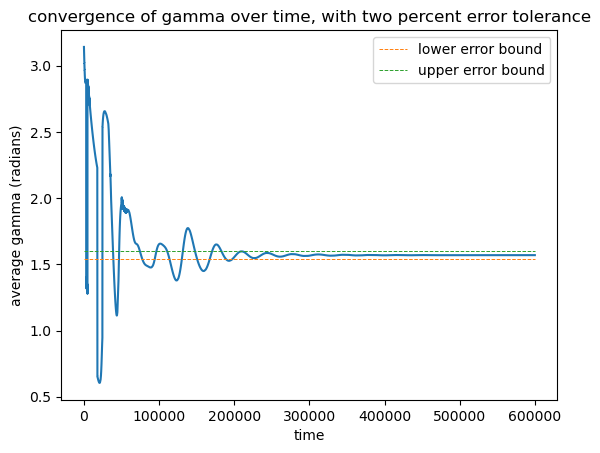

In [66]:
#plots average gamma vs time
bound_gamma = [np.pi/2 + np.pi/2 * tol, np.pi/2 - np.pi/2 * tol]
gamma_save = np.array(gamma_save)
avg_gamma = np.empty([gamma_save.shape[0],1])

for i in range(gamma_save.shape[0]):
    avg_gamma[i] = np.average(gamma_save[i,:])
plt.plot(avg_gamma)
plt.plot([0, 600000],[bound_gamma[1],bound_gamma[1]], linestyle = '--', linewidth = 0.7, label = 'lower error bound')
plt.plot([0, 600000],[bound_gamma[0],bound_gamma[0]], linestyle = '--', linewidth = 0.7, label = 'upper error bound')
plt.xlabel('time')
plt.ylabel('average gamma (radians)')
ax = plt.gca()
ax.legend()
ax.set_title('convergence of gamma over time, with two percent error tolerance')
plt.show()



In [41]:
np.array(theta_dot_save).shape
Error_percent[-1]

array([1.62540376])

In [49]:
bound

[27.212606049717287, 26.14544502815975]